In [4]:
import torch
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

# **Manual data generation**

In [168]:
X = torch.normal(0.0, 1.0, (1000, 2))
A = torch.tensor([[-4, 2],
                  [-1, -0.5]])
b = torch.tensor([1, 1])

In [169]:
X = torch.matmul(X, A) + b

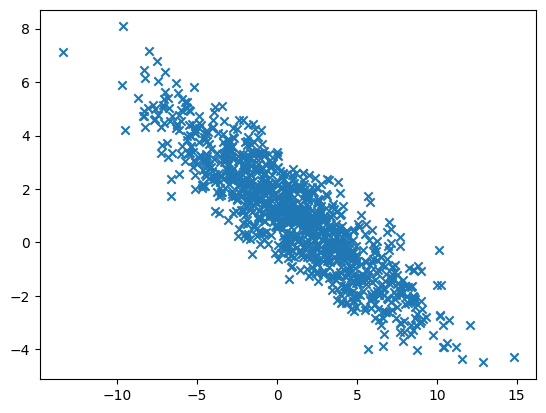

In [170]:
plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], marker='x')
plt.show()

# **Model initialization**

In [171]:
generator = nn.Sequential(nn.Linear(2, 2),).to(device)

In [172]:
discriminator = nn.Sequential(nn.Linear(2, 8), 
                              nn.ReLU(), 
                              nn.Linear(8, 1)).to(device)

# **Dataset**

In [173]:
from torch.utils.data import Dataset

class TwoDataset(Dataset):
    def __init__(self, data):
        self.data = data
    

    def __getitem__(self, index):
        return self.data[index]
    

    def __len__(self):
        return len(self.data)

In [174]:
data = TwoDataset(X)

## **Training**

In [175]:
def update_discriminator(X, Z, discriminator, generator, loss, optim_D):
    # Generating true and false arrays
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)

    # Nulling the optimizer gradient
    optim_D.zero_grad()

    # Generating predictions
    Y_real = discriminator(X)
    X_fake = generator(Z)
    Y_fake = discriminator(X_fake.detach())

    # Computing loss
    loss_D = loss(Y_real, ones.reshape(Y_real.shape)) + loss(Y_fake, zeros.reshape(Y_fake.shape))
    loss_D /= 2

    # Updating values
    loss_D.backward()
    optim_D.step()

    return loss_D

In [176]:
def update_generator(Z, discriminator, generator, loss, optim_G):
    # Generating true and false arrays
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)

    # Nulling the generator optimizer
    optim_G.zero_grad()

    # Generating predictions
    X_fake = generator(Z)
    Y_fake = discriminator(X_fake)

    # Computing loss
    loss_G = loss(Y_fake, ones.reshape(Y_fake.shape))

    # Updating values
    loss_G.backward()
    optim_G.step()

    return loss_G


In [177]:
from torch.utils.data import DataLoader

batch_size = 32
loader = DataLoader(data, batch_size=batch_size)

In [178]:
def train(discriminator, generator, dataloader, num_epochs, lr_D, lr_G, latent_dim, device):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    
    for w in discriminator.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in generator.parameters():
        nn.init.normal_(w, 0, 0.02)

    optim_D = torch.optim.Adam(discriminator.parameters(), lr=lr_D)
    optim_G = torch.optim.Adam(generator.parameters(), lr=lr_G)

    for epoch in range(num_epochs):
        for i, X in enumerate(dataloader):
            X = X.to(device)
            Z = torch.normal(0, 1, size=(X.shape[0], latent_dim)).to(device)
            loss_D = update_discriminator(X, Z, discriminator, generator, loss, optim_D)
            loss_G = update_generator(Z, discriminator, generator, loss, optim_G)
        
        print(f'Epoch {epoch} | Loss_D = {loss_D} | Loss_G = {loss_G}')
            

In [179]:
train(discriminator, generator, loader, 20, 0.05, 0.005, 2, device)

Epoch 0 | Loss_D = 0.924761950969696 | Loss_G = 13.280391693115234
Epoch 1 | Loss_D = 0.6361514329910278 | Loss_G = 20.562177658081055
Epoch 2 | Loss_D = 1.9117218255996704 | Loss_G = 19.08452033996582
Epoch 3 | Loss_D = 4.205541610717773 | Loss_G = 17.581462860107422
Epoch 4 | Loss_D = 5.4268999099731445 | Loss_G = 11.750805854797363
Epoch 5 | Loss_D = 4.505064964294434 | Loss_G = 13.734538078308105
Epoch 6 | Loss_D = 4.925486087799072 | Loss_G = 11.413854598999023
Epoch 7 | Loss_D = 5.415564060211182 | Loss_G = 9.467525482177734
Epoch 8 | Loss_D = 4.529677391052246 | Loss_G = 11.053749084472656
Epoch 9 | Loss_D = 5.8742995262146 | Loss_G = 6.928927421569824
Epoch 10 | Loss_D = 4.498821258544922 | Loss_G = 9.78723430633545
Epoch 11 | Loss_D = 4.872894287109375 | Loss_G = 8.646644592285156
Epoch 12 | Loss_D = 5.040192604064941 | Loss_G = 8.203017234802246
Epoch 13 | Loss_D = 5.3911261558532715 | Loss_G = 7.13178014755249
Epoch 14 | Loss_D = 4.923346042633057 | Loss_G = 7.98830986022949

# **Results**

In [183]:
Z = torch.normal(0, 1, (X.shape[0], X.shape[1]))
Y = generator(Z.to(device)).to('cpu').detach()

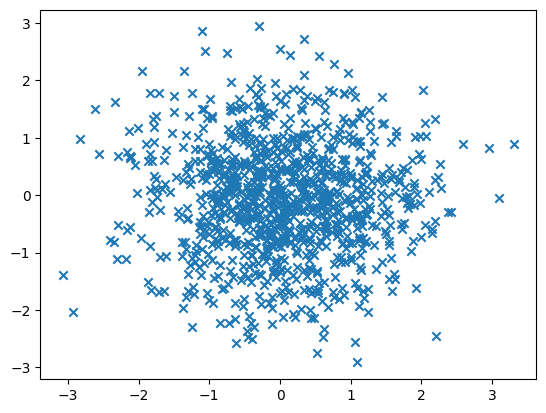

In [186]:
plt.scatter(Z.numpy()[:, 0], Z.numpy()[:, 1], marker='x')
plt.show()

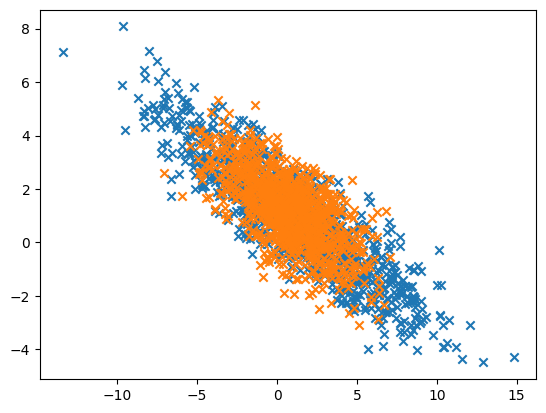

In [187]:
plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], marker='x')
plt.scatter(Y.numpy()[:, 0], Y.numpy()[:, 1], marker='x')
plt.show()

In [128]:
net_G = nn.Sequential(nn.Linear(2, 2))

net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1))

def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
    loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

def train(net_D, net_G, loader, num_epochs, lr_D, lr_G, latent_dim):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    for epoch in range(num_epochs):
    # Train one epoch
    
        for i, asd in enumerate(loader):
            batch_size = asd.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            update_D(asd, Z, net_D, net_G, loss, trainer_D)
            update_G(asd, net_D, net_G, loss, trainer_G)
    